torch.Size([10000, 3])


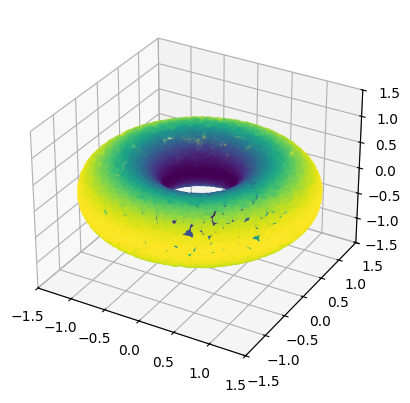

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the model
class AE(nn.Module):
    def __init__(self, latent_dim=16):
        super(AE, self).__init__()
        # self.latent_dim = latent_dim
        self.latent_dim = 3
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 4),
            # nn.Tanh(), # Constrain to -1, 1
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28),
        )

    def encode(self, x):
        l = self.encoder(x)

        # We limit to 3-D Torus. First is extract two dimensions
        d1 = l[:, :2] # [B, 2]
        d1 = d1 / torch.norm(d1, dim=1, keepdim=True) # [B, 2]
        d1 = torch.cat((d1, torch.zeros((d1.shape[0], 1), device=x.device, dtype=x.dtype)), dim=1) # [B, 3]
        d2 = l[:, 2:].unsqueeze(1) # [B, 1, 2]
        d2 = d2 / torch.norm(d2, dim=2, keepdim=True) # [B, 1, 2]
        v1 = torch.cat(
            (
                torch.zeros((d2.shape[0], 1, 2), device=x.device, dtype=x.dtype), 
                torch.ones((d2.shape[0], 1, 1), device=x.device, dtype=x.dtype), 
            ),
        dim=2) # [B, 1, 3], is unit vector in z direction
        dbasis = torch.cat((d1.unsqueeze(1), v1), dim=1) # [B, 2, 3]
        d3 = d1.unsqueeze(1) + 0.5*torch.bmm(d2, dbasis) # [B, 1, 3]
        return d3.squeeze(1), l

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        h, l = self.encode(x)
        return self.decode(h), (h, l)
    
def draw_samples(samples):
    d1 = torch.randn(samples, 2)
    d1 = d1 / torch.norm(d1, dim=1, keepdim=True)
    d1 = torch.cat((d1, torch.zeros(samples, 1)), dim=1)
    d2 = torch.randn(samples, 1, 2)
    d2 = d2 / torch.norm(d2, dim=2, keepdim=True)
    v1 = torch.cat((torch.zeros(samples, 1, 2), torch.ones(samples, 1, 1)), dim=2)
    dbasis = torch.cat((d1.unsqueeze(1), v1), dim=1)
    d3 = d1.unsqueeze(1) + 0.5*torch.bmm(d2, dbasis)
    return d3.squeeze(1)

# Plot 3D samples colored by norm
d3 = draw_samples(10000)
print(d3.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d3[:, 0], d3[:, 1], d3[:, 2], c=torch.norm(d3, dim=1).detach().numpy())
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
plt.show()
plt.close()

In [2]:
# Build model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./mnist_data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

latent_dim = 12
myae = AE(latent_dim=latent_dim).to(device)

# Show variance of samples (diagonal)
mean_samples = torch.mean(d3, dim=0).to(device)
std_samples = torch.std(d3, dim=0, unbiased=True).to(device)
print(mean_samples)
print(std_samples)

Using device cuda
tensor([-0.0172, -0.0069, -0.0013], device='cuda:0')
tensor([0.7547, 0.7513, 0.3527], device='cuda:0')


In [5]:
import schedulefree
opt_ae = schedulefree.AdamWScheduleFree(myae.parameters(), lr=1e-3, betas=(0.95, 0.9999), weight_decay=1e-6, warmup_steps=100)
loss_fn = nn.L1Loss()
epochs = 200
pbar = tqdm(total=epochs)
for epoch in range(epochs):
    myae.train()
    for x, _ in train_loader:
        # Get reconstruction and latent representation
        opt_ae.train()
        x = x.to(device)
        opt_ae.zero_grad()
        recon, z = myae(x)

        # Reconstruction loss
        recon_loss = loss_fn(recon, x)

        # Moment matching
        reg_loss = (torch.mean(z[0], dim=0) - mean_samples).pow(2).sum()
        reg_loss = reg_loss + (torch.std(z[0], dim=0, unbiased=True) - std_samples).pow(2).sum()

        # Get gradients (automatic differentiation)
        loss = recon_loss + reg_loss
        loss.backward()
        opt_ae.step()
        pbar.set_postfix({'Loss': loss.item(), 'Recon': recon_loss.item(), 'Reg': reg_loss.item()})
    pbar.update(1)
pbar.close()
opt_ae.eval()

100%|██████████| 200/200 [49:48<00:00, 14.94s/it, Loss=0.177, Recon=0.147, Reg=0.0305]  


In [6]:
# Go through the entire training dataset and label the latent space
myae.eval()
all_latents = []
all_labels = []
for x, y in train_loader:
    x = x.to(device)
    with torch.no_grad():
        _, z = myae(x)
        z = z[0].cpu()
    all_latents.append(z)
    all_labels.append(y)
all_latents = torch.cat(all_latents)
all_labels = torch.cat(all_labels)

c:\Users\kevin\Desktop\Test\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


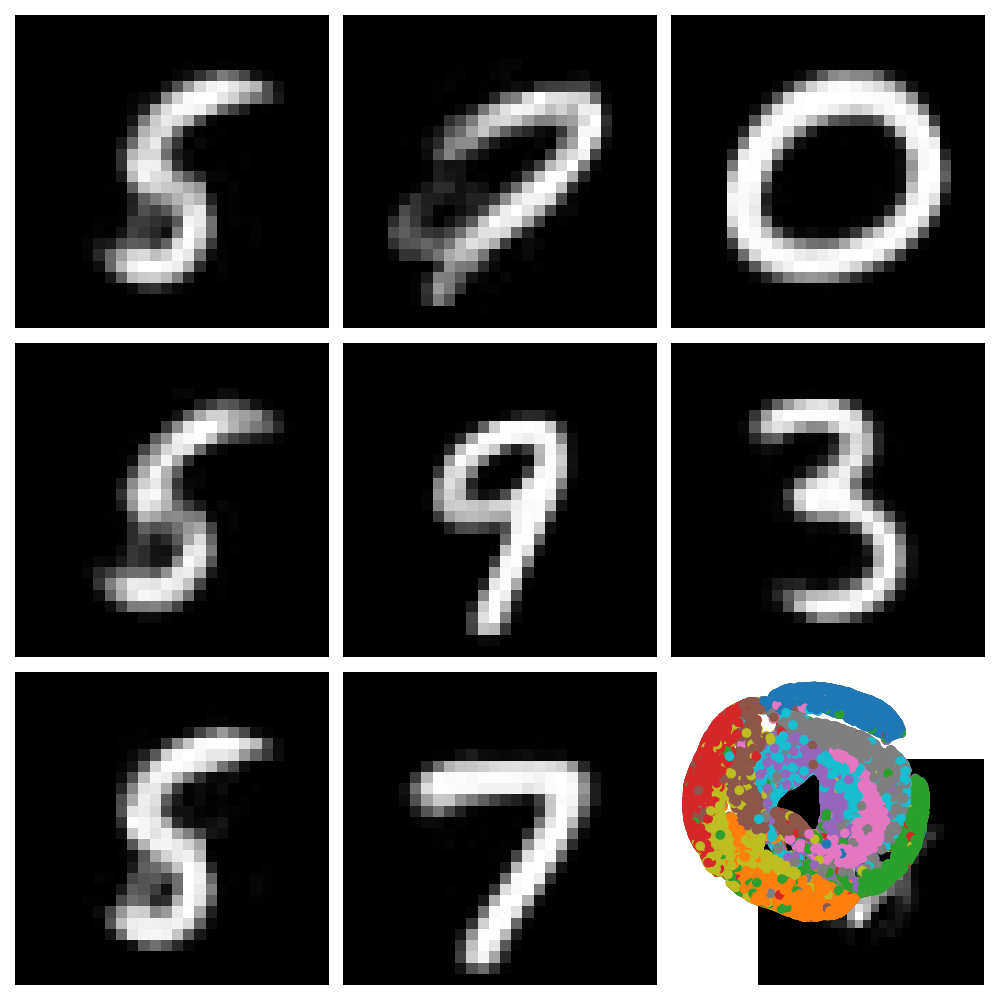

No such comm: 4bb25395c0eb40969b7ece6af36f81f5


In [9]:
import umap
# Umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_latents)

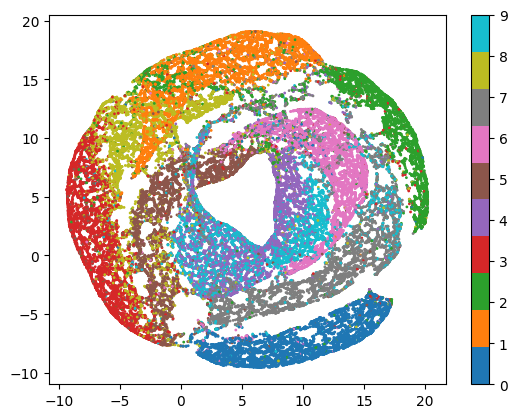

In [25]:
%matplotlib inline
plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels.cpu().numpy(), cmap='tab10', s=1)
plt.colorbar()
plt.show()
plt.close()

In [37]:
# UMAP on original data
reducer2 = umap.UMAP()
embedding2 = reducer2.fit_transform(train_dataset.data.view(-1, 28*28).numpy())

c:\Users\kevin\Desktop\Test\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


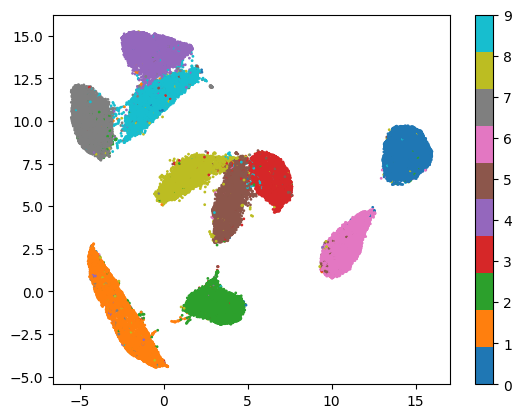

In [38]:
# Plot UMAP of original data
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=train_dataset.targets.numpy(), cmap='tab10', s=1)
plt.colorbar()
plt.show()
plt.close()

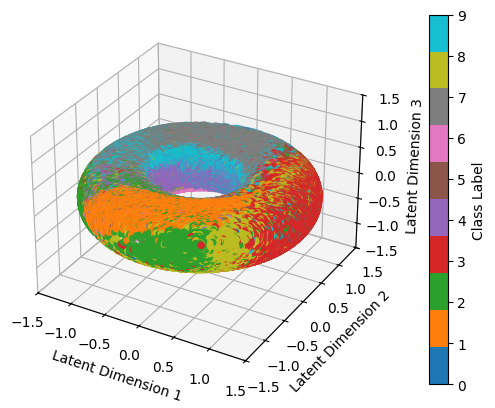

In [43]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget
%matplotlib inline

# Assuming all_latents and all_labels are already defined as in your code

# Convert tensors to numpy arrays for plotting
latents_np = all_latents.cpu().numpy()
labels_np = all_labels.cpu().numpy()

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color coding by class labels using tab10 colormap
scatter = ax.scatter(latents_np[:, 0], latents_np[:, 1], latents_np[:, 2], c=labels_np, cmap='tab10')

# Add a color bar
colorbar = fig.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_label('Class Label')

# Set labels for axes
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
# ax.view_init(elev=-30, azim=30)  # You can change these values to your preferred angles

# Show plot
plt.show()
plt.close()

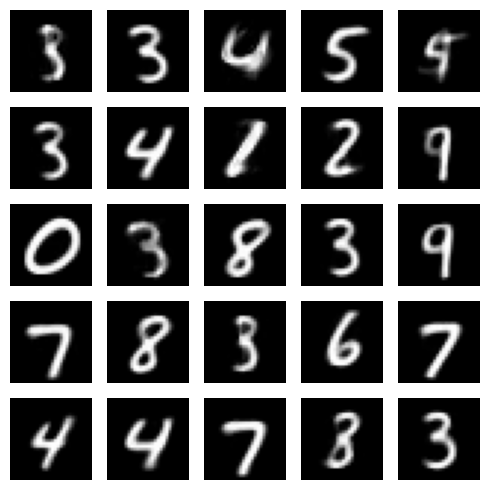

In [91]:
import matplotlib.pyplot as plt
import torch
# Draw samples from AE
myae.eval()
samples = draw_samples(25).to(device)
recon = myae.decode(samples)

# Determine grid size (close to square)
num_samples = samples.shape[0]
grid_size = int(num_samples**0.5)
if grid_size**2 < num_samples:
    grid_size += 1

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# Plot samples in grid
for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        if idx < num_samples:
            img = recon[idx].cpu().detach().numpy().squeeze()  # Assuming recon is in CHW format
            img = img.clip(-1, 1)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()